In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# ▶ 1. Carregar dados
data = pd.read_csv("./data/data_prepro.csv")
print(data.columns)


# ▶ 2. Recorte de ~29k (exatamente como na sequência 1)
class_counts = data['Attack Type'].value_counts()
selected_classes = class_counts[class_counts > 1950].index
selected = data[data['Attack Type'].isin(selected_classes)]

dfs = []
for name in selected_classes:
    df_class = selected[selected['Attack Type'] == name]
    if len(df_class) > 2500:
        df_class = df_class.sample(n=5000, random_state=0)
    dfs.append(df_class)

df = pd.concat(dfs, ignore_index=True)

# ▶ 3. Separar features e labels
X = df.drop('Attack Type', axis=1)
if 'Fwd Header Length.1' in X.columns:
    X = X.drop(columns=['Fwd Header Length.1'])
y = df['Attack Type']

# ▶ 4. train/test split no recorte reduzido
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Index(['Dst Port', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min',
       'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count

In [2]:
# ▶ 5. Construir o pipeline com SMOTE
size = X_train.shape[1] // 2
pipe = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('ipca', IncrementalPCA(n_components=size, batch_size=500)),
    ('smote', SMOTE(random_state=0)),
    ('clf', RandomForestClassifier(n_estimators=15, max_depth=8, max_features=20, random_state=0))
])

In [3]:
# ▶ 3. treina (fit) **apenas** nos dados de treino
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ipca', IncrementalPCA(batch_size=500, n_components=34)),
                ('smote', SMOTE(random_state=0)),
                ('clf',
                 RandomForestClassifier(max_depth=8, max_features=20,
                                        n_estimators=15, random_state=0))])

In [15]:
import joblib
joblib.dump(pipe, 'modelos/modelo.pkl')

['modelos/modelo.pkl']

# Validacao

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#pipe = joblib.load('modelos/modelo.pkl')

In [6]:
y_pred= pipe.predict(X_test)

cv = cross_val_score(pipe, X_test, y_test, cv = 5)
print('Random Forest Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv)))
print(f'\nMean cross-validation score: {cv.mean():.2f}')

Random Forest Model 2

Cross-validation scores: 0.9766323024054983, 0.9786941580756013, 0.9821305841924398, 0.9807560137457044, 0.982806052269601

Mean cross-validation score: 0.98


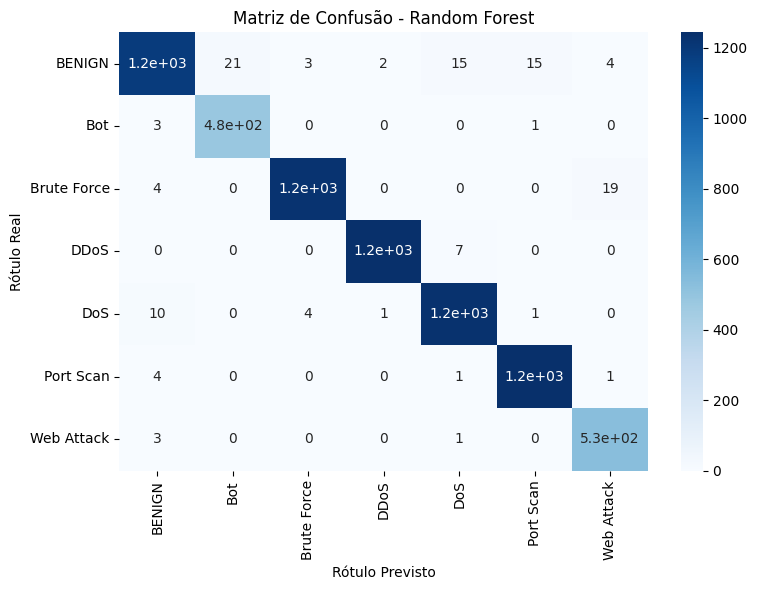

In [7]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=pipe.classes_, yticklabels=pipe.classes_)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.tight_layout()
plt.show()

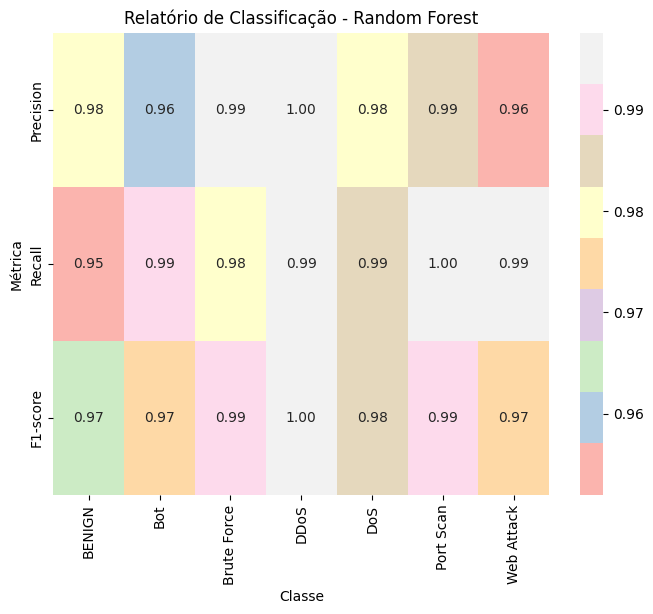

In [8]:
target_names = pipe.classes_
metrics = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)

precision = [metrics[target]['precision'] for target in target_names]
recall = [metrics[target]['recall'] for target in target_names]
f1 = [metrics[target]['f1-score'] for target in target_names]

data = [precision, recall, f1]
rows = ['Precision', 'Recall', 'F1-score']

plt.figure(figsize=(8, 6))
sns.heatmap(data, cmap='Pastel1', annot=True, fmt='.2f', xticklabels=target_names, yticklabels=rows)
plt.title('Relatório de Classificação - Random Forest')
plt.xlabel('Classe')
plt.ylabel('Métrica')
plt.show()

# Teste com dados reais

In [ ]:
data = pd.read_csv("./data/real_data.csv")
#data = pd.read_csv("./data/dos_simulation.csv")
#data = pd.read_csv("./data/portscan_simulation.csv")
#data = pd.read_csv("./data/real_data.csv")

In [28]:
data["Protocol"].unique()

array([6])

In [17]:
pipe = joblib.load('modelos/modelo.pkl')
features_treinadas = pipe.named_steps["scaler"].feature_names_in_
data = data[list(features_treinadas)]

In [18]:
import numpy as np

data.replace([np.inf, -np.inf], np.nan, inplace = True)
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

data['Flow Bytes/s'] = data['Flow Bytes/s'].fillna(med_flow_bytes)
data['Flow Packets/s'] = data['Flow Packets/s'].fillna(med_flow_packets)


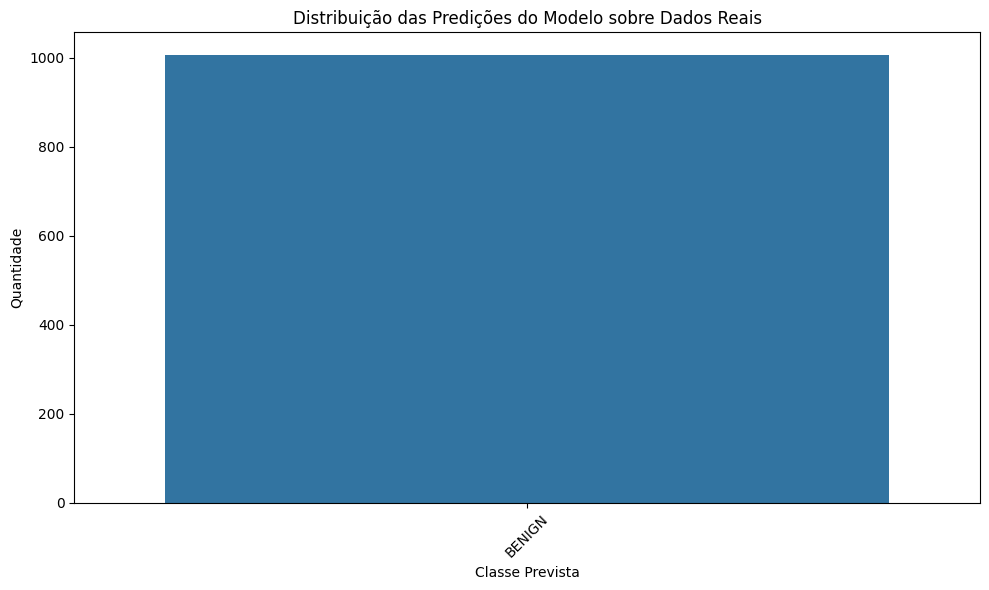

In [19]:
#data.head(10).iloc[:, -5:]
#data.head(10)
# ▶ 4. Fazer predições

y_pred_real = pipe.predict(data)

# ▶ 5. Mostrar distribuição de predições
plt.figure(figsize=(10, 6))
sns.countplot(x=y_pred_real, order=pd.Series(y_pred_real).value_counts().index)
plt.title("Distribuição das Predições do Modelo sobre Dados Reais")
plt.xlabel("Classe Prevista")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
